## Day 30 Lecture 2 Assignment

In this assignment, we will learn about random forests. We will use the google play store dataset loaded below.

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report

from category_encoders import LeaveOneOutEncoder


In [19]:
def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

In [2]:
reviews = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/googleplaystore.csv')

reviews.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In this assignment, you will work more independently. Perform the following steps:
    
1. Select which columns are best suited to predict whether the rating is above 4.5
2. Process the data (including transforming to the correct column type, removing missing values, creating dummy variables, and removing irrelevant variables)
3. Create a random forest model and evaluate
4. Using grid search cross validation, tweak the parameters to produce a better performing model
5. Show and discuss your results

Good luck!

In [3]:
reviews.info()
# few enough na's to drop

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [4]:
reviews = reviews.dropna()
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9360 non-null   object 
 1   Category        9360 non-null   object 
 2   Rating          9360 non-null   float64
 3   Reviews         9360 non-null   object 
 4   Size            9360 non-null   object 
 5   Installs        9360 non-null   object 
 6   Type            9360 non-null   object 
 7   Price           9360 non-null   object 
 8   Content Rating  9360 non-null   object 
 9   Genres          9360 non-null   object 
 10  Last Updated    9360 non-null   object 
 11  Current Ver     9360 non-null   object 
 12  Android Ver     9360 non-null   object 
dtypes: float64(1), object(12)
memory usage: 1023.8+ KB


In [5]:
reviews.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [6]:
cols_of_interest = [
    'Category',
    'Reviews',
    # 'Last Updated',
    'Installs',
    'Content Rating',
    'Type'
]

In [7]:
X = reviews[cols_of_interest]
y = reviews['Rating']

In [8]:
X['Category'].value_counts()

FAMILY                 1746
GAME                   1097
TOOLS                   733
PRODUCTIVITY            351
MEDICAL                 350
COMMUNICATION           328
FINANCE                 323
SPORTS                  319
PHOTOGRAPHY             317
LIFESTYLE               314
PERSONALIZATION         312
BUSINESS                303
HEALTH_AND_FITNESS      297
SOCIAL                  259
SHOPPING                238
NEWS_AND_MAGAZINES      233
TRAVEL_AND_LOCAL        226
DATING                  195
BOOKS_AND_REFERENCE     178
VIDEO_PLAYERS           160
EDUCATION               155
ENTERTAINMENT           149
MAPS_AND_NAVIGATION     124
FOOD_AND_DRINK          109
HOUSE_AND_HOME           76
WEATHER                  75
AUTO_AND_VEHICLES        73
LIBRARIES_AND_DEMO       64
ART_AND_DESIGN           61
COMICS                   58
PARENTING                50
EVENTS                   45
BEAUTY                   42
Name: Category, dtype: int64

In [9]:
# process feature columns
cat_cols = [
    'Category',
    'Content Rating',
    'Type'
]

num_cols = [
    'Reviews',
    'Installs',
    ]

date_cols = ['Last Updated']

X['Reviews'] = X['Reviews'].apply(pd.to_numeric)
X['Installs'] = X['Installs'].str.replace('+', '')
X['Installs'] = X['Installs'].str.replace(',', '')
X['Installs'] = X['Installs'].apply(pd.to_numeric)


C:\Users\dgump\miniconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\dgump\miniconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\dgump\miniconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [10]:
#X['Last Updated'] = X['Last Updated'].apply(pd.to_datetime)

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Category        9360 non-null   object
 1   Reviews         9360 non-null   int64 
 2   Installs        9360 non-null   int64 
 3   Content Rating  9360 non-null   object
 4   Type            9360 non-null   object
dtypes: int64(2), object(3)
memory usage: 438.8+ KB


In [12]:
# split before treatments
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [13]:
encoder = LeaveOneOutEncoder(cols=cat_cols)
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7488 entries, 6986 to 1970
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        7488 non-null   float64
 1   Reviews         7488 non-null   int64  
 2   Installs        7488 non-null   int64  
 3   Content Rating  7488 non-null   float64
 4   Type            7488 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 351.0 KB


In [15]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [16]:
rf_model.score(X_train, y_train)

0.7993176727123541

In [18]:
rf_model.score(X_test, y_test)

0.07545351155933278

rmse 0.50
mae 0.32
mape 0.09


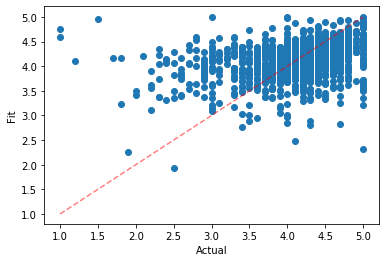

In [20]:
y_pred = rf_model.predict(X_test)

eval_preds(y_test, y_pred)

In [22]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [34]:
grid = [
    {'max_depth': [5,6,7,8]},
    #{'max_leaf_node': [1,5,10]},
    {'n_estimators': [10,100, 1000]}
]
    


model = GridSearchCV(RandomForestRegressor(), param_grid= grid, cv=5 )

In [35]:
model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [36]:
model.best_params_

{'max_depth': 8}